In [1]:
from shearletNN.shearlets import getcomplexshearlets2D
from shearletNN.shearlet_utils import (
    frequency_shearlet_transform,
    spatial_shearlet_transform,
    ShearletTransformLoader,
    shifted_frequency_shearlet_transform,
    shifted_spatial_shearlet_transform,
    hartley_shearlet_transform,
)
from shearletNN.complex_resnet import (
    complex_resnet18,
    complex_resnet34,
    complex_resnet50,
)

from shearletNN.layers import CGELU, CReLU

import torch
import torchvision
from torchvision.transforms import v2
from torchvision import transforms

import gc
from tqdm import tqdm
import matplotlib.pyplot as plt


patch_size = 16
image_size = 64

rows, cols = image_size, image_size


shearlets, shearletIdxs, RMS, dualFrameWeights = getcomplexshearlets2D(
    rows,
    cols,
    1,  # scales per octave
    3,  # shear level (something like O(log of directions))
    1,  # octaves
    0.5,  # alpha
    wavelet_eff_support=image_size,
    gaussian_eff_support=image_size,
)

shearlets = torch.tensor(shearlets).permute(2, 0, 1).type(torch.complex64).to(0)

In [2]:
from torch.amp import GradScaler, autocast

def train(model, optimizer, loader, accumulate=1):
    model.train()
    loss = torch.nn.CrossEntropyLoss()

    scaler = GradScaler()

    for i, (X, y) in tqdm(enumerate(loader)):
        out = model(X.to(0))

        with autocast(device_type='cuda', dtype=torch.float16):
            l = loss(out, y.to(0)) / accumulate

        scaler.scale(l).backward()

        if i % accumulate == (accumulate - 1):
            scaler.step(optimizer) # .step()
            scaler.update()
            optimizer.zero_grad()


def accuracy(output, target, topk=(1,)):
    output = output.to(torch.device("cpu"))
    target = target.to(torch.device("cpu"))
    maxk = max(topk)
    batch_size = target.shape[0]

    _, idx = output.sort(dim=1, descending=True)
    pred = idx.narrow(1, 0, maxk).t()
    correct = pred.eq(target.reshape(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(dim=0, keepdim=True)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res


def epoch_accuracy(loader_s, student):
    student.eval()

    out_epoch_s = [
        accuracy(student(L.to(0)), y)[0].detach().cpu().item() for L, y in loader_s
    ]

    student.train()

    return sum(out_epoch_s) / len(out_epoch_s)


def test(network, test_loader):
    network.eval().to(0)
    test_loss = 0
    correct = 0
    total = 0
    test_losses = []
    with torch.no_grad():
        for data, target in test_loader:
            output = network(data.to(0))
            test_loss += torch.nn.CrossEntropyLoss()(output, target.to(0)).item()
            pred = output.data.max(1, keepdim=True)[1].cpu()
            correct += pred.eq(target.data.view_as(pred)).sum()
            total += target.shape[0]
        test_loss /= total
        test_losses.append(test_loss)
        print(
            "\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n".format(
                test_loss, correct, total, 100.0 * correct / total
            )
        )


class IndexSubsetDataset:
    def __init__(self, ds, inds):
        self.ds = ds
        self.inds = inds

    def __iter__(self):
        for i in range(len(self.inds)):
            yield self[i]

    def __getitem__(self, i):
        return self.ds[self.inds[i]]

    def __len__(self):
        return len(self.inds)


def linearleaves(module):
    # returns a list of pairs of (parent, submodule_name) pairs for all submodule leaves of the current module
    if isinstance(module, torch.nn.Linear):
        return [(module, None)]

    linear_children = []
    for name, mod in module.named_modules():
        if isinstance(mod, torch.nn.Linear):
            linear_children.append((name, module))
    return linear_children

In [3]:
def linearleaves(module):
    # returns a list of pairs of (parent, submodule_name) pairs for all submodule leaves of the current module
    if isinstance(module, torch.nn.Linear):
        return [(module, None)]

    linear_children = []
    for name, mod in module.named_modules():
        if isinstance(mod, torch.nn.Linear) or isinstance(mod, torch.nn.Conv2d):
            linear_children.append((name, module))
    return linear_children


def getattrrecur(mod, s):
    s = s.split(".")
    for substr in s:
        mod = getattr(mod, substr)
    return mod


def setattrrecur(mod, s, value):
    s = s.split(".")
    for substr in s[:-1]:
        mod = getattr(mod, substr)
    setattr(mod, s[-1], value)


def spectral_normalize(model):
    for name, mod in linearleaves(model):
        setattrrecur(
            model,
            name,
            torch.nn.utils.parametrizations.spectral_norm(getattrrecur(mod, name)),
        )

    return model

In [4]:
def batch_cov_3d(points, mean):
    """
    for our purposes we want to batch the covariance along the channel dimension (originally 1) and compute it over the batch dimension (originally 0)

    we need a covariance matrix for each channel along the batch dimension, so of shape (C, 2, 2)

    Input: points \in (B, C, H, W, D)

    """
    points = points - mean
    points = points.permute(1, 0, 2, 3, 4)  # Channels first for the reshape
    C, B, H, W, D = points.size()
    N = B * H * W
    diffs = points.reshape(C * N, D)
    prods = torch.bmm(diffs.unsqueeze(2), diffs.unsqueeze(1)).reshape(C, N, D, D)
    bcov = prods.sum(dim=1) / N
    return bcov  # (C, D, D)


def loader_mean_cov(loader):
    total = 0
    mean = None
    cov = None

    for x, y in loader:
        total += 1
        if mean is None:
            mean = torch.mean(x, dim=(0, 2, 3), keepdim=True).unsqueeze(-1)

        else:
            mean += torch.mean(x, dim=(0, 2, 3), keepdim=True).unsqueeze(-1)
            
        if cov is None:
            cov = batch_cov_3d(x.unsqueeze(-1), mean)

        else:
            cov = ( ( (total - 2) / (total - 1) ) * cov ) + ( (1 / total) * batch_cov_3d(x.unsqueeze(-1), mean / total ) )

    return mean, cov


class Normalizer:
    def __init__(self, mean, cov, eps=1e-6):
        self.mean = mean
        self.cov = cov
        self.epsilon_matrix = torch.eye(1) * eps

        # Inv and sqrtm is done over 2 inner most dimension [..., M, M] so it should be [..., 2, 2] for us.
        # torch has no matrix square root, so we have
        L, Q = torch.linalg.eigh(
            torch.linalg.inv((self.cov + self.epsilon_matrix.unsqueeze(0).to(self.cov.device)).to(torch.float64))
        )  # low precision dtypes not supported
        # eigenvalues of positive semi-definite matrices are always real (and non-negative)
        diag = torch.diag_embed(L ** (0.5))
        self.inv_sqrt_var = Q @ diag @ Q.mH  # var^(-1/2), (C, 2, 2)

    def __call__(self, inputs):
        # Separate real and imag so I go from shape [...] to [..., 2]
        inputs = inputs.unsqueeze(-1)

        zero_mean = inputs - self.mean
        # (C, 2, 2) @ (B, H, W, C, 2, 1) -> (B, H, W, C, 2, 1)
        inputs_hat = torch.matmul(
            self.inv_sqrt_var.to(inputs.dtype), zero_mean.permute(0, 2, 3, 1, 4).unsqueeze(-1)
        )
        # Then I squeeze to remove the last shape so I go from [..., 2, 1] to [..., 2].
        # Use reshape and not squeeze in case I have 1 channel for example.
        squeeze_inputs_hat = torch.reshape(inputs_hat, shape=inputs_hat.shape[:-1]).permute(0, 3, 1, 2, 4)
        # Get complex data
        complex_inputs_hat = squeeze_inputs_hat[..., 0]

        return complex_inputs_hat

In [5]:
batch_size_train = 128

In [6]:
from shearletNN.complex_deit import (
    vit_models,
    LPatchEmbed,
    Attention,
    Block,
    ComplexLayerNorm,
    complex_Lfreakformer_small_patch1_LS,
)
from shearletNN.layers import CReLU, ComplexLayerNorm
from functools import partial


def repeat3(x):
    return x.repeat(3, 1, 1)[:3]


train_transform = v2.Compose(
    [
        transforms.RandomResizedCrop((image_size, image_size), scale=(0.5, 1.0)),
        # transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        repeat3,
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

val_transform = v2.Compose(
    [
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        repeat3,
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

ds_train = torchvision.datasets.Caltech101(
    "./", transform=train_transform, download=True
)
ds_train = IndexSubsetDataset(
    ds_train, sum([list(range(len(ds_train)))[i::5] for i in range(1, 5)], [])
)

ds_val = torchvision.datasets.Caltech101("./", transform=val_transform, download=True)
ds_val = IndexSubsetDataset(ds_val, list(range(len(ds_val)))[0::5])


ds_train = torchvision.datasets.CIFAR10(
    "../", transform=train_transform, download=True, train=True
)

ds_val = torchvision.datasets.CIFAR10(
    "../", transform=val_transform, download=True, train=False
)


train_loader = torch.utils.data.DataLoader(
    ds_train, batch_size=batch_size_train, shuffle=True, num_workers=0
)

shearlets = shearlets[:]


def symlog(x, threshold=1):
    return torch.sign(x) * torch.log(1 + torch.abs(x / threshold))

def symsqrt(x):
    return torch.sign(x) * torch.sqrt(torch.abs(x))

def complex_symsqrt(x):
    real = x.real
    imag = x.imag

    return torch.complex(symsqrt(real), symsqrt(imag))

def complex_symlog(x, threshold=1):
    real = x.real
    imag = x.imag

    return torch.complex(symlog(real, threshold), symlog(imag, threshold))

def shearlet_transform(img):
    return symsqrt(hartley_shearlet_transform(img.to(0), shearlets.to(0), patch_size))


train_loader = ShearletTransformLoader(train_loader, shearlet_transform)


mean, cov = loader_mean_cov(tqdm(train_loader))

norm = Normalizer(mean, cov)

/home/jroth/miniforge3/envs/shearlets/lib/python3.9/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/home/jroth/miniforge3/envs/shearlets/lib/python3.9/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


391it [00:09, 41.21it/s]


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/98 [00:00<?, ?it/s]

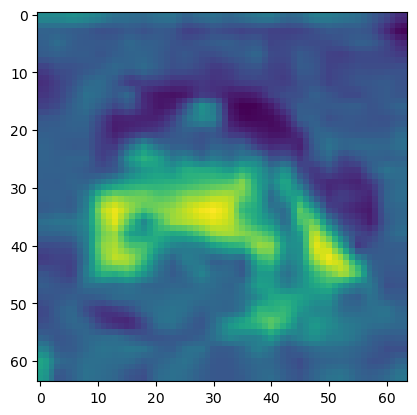

  0%|          | 0/98 [00:00<?, ?it/s]
0it [00:00, ?it/s]

tensor([-1.0448, -1.0456, -1.0471,  0.2261,  0.2253,  0.2251,  0.2250,  0.2252,
         1.0454,  1.0447, -5.1674, -5.1698, -5.1787,  0.4674,  0.4665,  0.4661,
         0.4661,  0.4666,  5.1805,  5.1709, -6.5974, -6.5998, -6.6082,  0.9384,
         0.9361,  0.9350,  0.9350,  0.9364,  6.6115,  6.6016], device='cuda:0')
tensor([0.4873, 0.4873, 0.4873, 0.4892, 0.4892, 0.4892, 0.4892, 0.4892, 0.4873,
        0.4873, 0.4795, 0.4795, 0.4795, 0.4826, 0.4826, 0.4826, 0.4826, 0.4826,
        0.4795, 0.4795, 0.4807, 0.4807, 0.4807, 0.4859, 0.4859, 0.4859, 0.4859,
        0.4859, 0.4807, 0.4807], device='cuda:0')
tensor(8.2122, device='cuda:0')


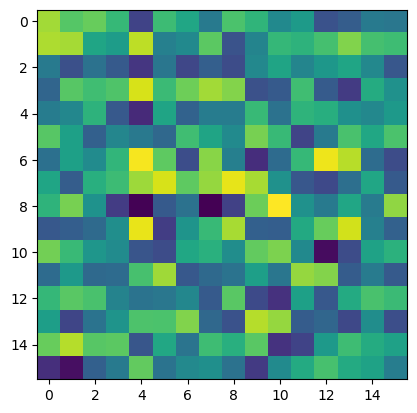

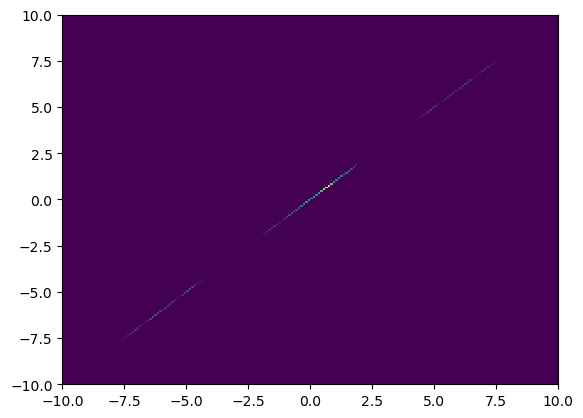

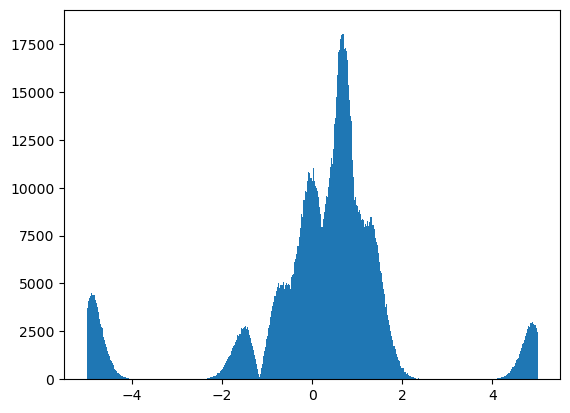

0it [00:00, ?it/s]

building model...


In [7]:
from shearletNN.complex_deit import (
    vit_models,
    LPatchEmbed,
    Attention,
    Block,
    ComplexLayerNorm,
    complex_Lfreakformer_small_patch1_LS,
)
from shearletNN.layers import CReLU, ComplexLayerNorm
from functools import partial


def repeat3(x):
    return x.repeat(3, 1, 1)[:3]


train_transform = v2.Compose(
    [
        transforms.RandomResizedCrop((image_size, image_size), scale=(0.5, 1.0)),
        transforms.RandomHorizontalFlip(),
        # transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        repeat3,
        # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

val_transform = v2.Compose(
    [
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        repeat3,
        # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

ds_train = torchvision.datasets.Caltech101(
    "./", transform=train_transform, download=True
)
ds_train = IndexSubsetDataset(
    ds_train, sum([list(range(len(ds_train)))[i::5] for i in range(1, 5)], [])
)

ds_val = torchvision.datasets.Caltech101("./", transform=val_transform, download=True)
ds_val = IndexSubsetDataset(ds_val, list(range(len(ds_val)))[0::5])


ds_train = torchvision.datasets.CIFAR10(
    "../", transform=train_transform, download=True, train=True
)

ds_val = torchvision.datasets.CIFAR10(
    "../", transform=val_transform, download=True, train=False
)


train_loader = torch.utils.data.DataLoader(
    ds_train, batch_size=512, shuffle=False, num_workers=0
)

for x, y in tqdm(train_loader):
    plt.imshow(x[0].sum(0).real.cpu().numpy())
    plt.show()
    break

shearlets = shearlets[:]


def shearlet_transform(img):

    return norm(symsqrt(hartley_shearlet_transform(img.to(0), shearlets.to(0), patch_size)))


train_loader = ShearletTransformLoader(train_loader, shearlet_transform)

val_loader = torch.utils.data.DataLoader(
    ds_val, batch_size=batch_size_train, shuffle=False
)

val_loader = ShearletTransformLoader(val_loader, shearlet_transform)

for x, y in tqdm(train_loader):
    assert list(x.shape) == [
        512,
        shearlets.shape[0] * 3,
        patch_size,
        patch_size,
    ], x.shape
    assert x.dtype == torch.float32, x.dtype
    print(x.real.mean((0, 2, 3)))

    print(x.real.std((0, 2, 3)))

    print(x.real.max())

    plt.imshow(x[0].sum(0).real.cpu().numpy())
    plt.show()
    plt.hist2d(x.flatten().real.cpu().numpy(), x.flatten().real.cpu().numpy(), bins=200, range=[[-10, 10], [-10, 10]])
    plt.show()
    plt.hist(x.flatten().real.cpu().numpy(), bins=1023, range=[-5, 5])
    plt.show()

    break
print("building model...")


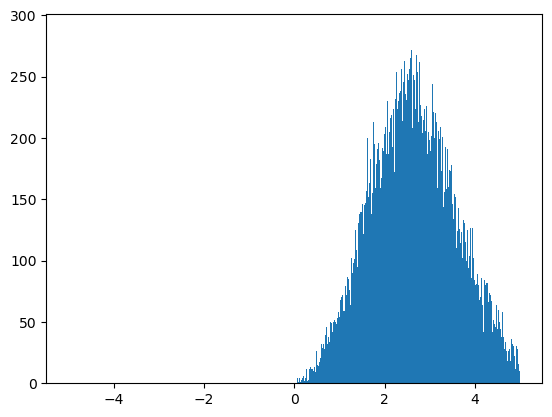

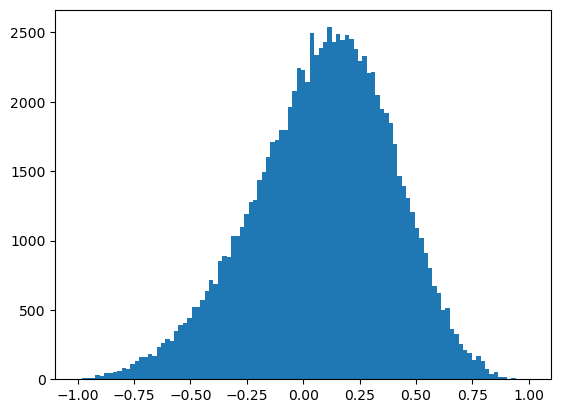

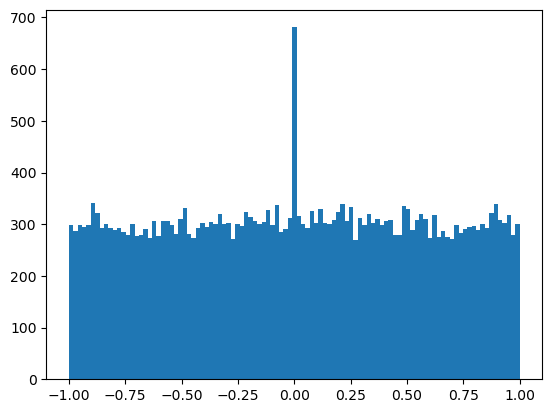

training model...
epoch 0


391it [00:38, 10.26it/s]


epoch 1


391it [00:15, 25.32it/s]


epoch 2


391it [00:15, 25.13it/s]


epoch 3


391it [00:15, 24.91it/s]


epoch 4


391it [00:15, 24.92it/s]


epoch 5


391it [00:15, 25.08it/s]


epoch 6


391it [00:15, 25.78it/s]


epoch 7


391it [00:15, 25.61it/s]



Test set: Avg. loss: 0.0102, Accuracy: 26969/50000 (54%)


Test set: Avg. loss: 0.0102, Accuracy: 5434/10000 (54%)

epoch 8


391it [00:15, 25.28it/s]


epoch 9


391it [00:15, 25.06it/s]


epoch 10


391it [00:15, 25.31it/s]


epoch 11


391it [00:15, 24.81it/s]


epoch 12


391it [00:15, 25.37it/s]


epoch 13


391it [00:15, 25.46it/s]


epoch 14


391it [00:15, 25.52it/s]


epoch 15


391it [00:15, 25.31it/s]



Test set: Avg. loss: 0.0087, Accuracy: 30335/50000 (61%)


Test set: Avg. loss: 0.0085, Accuracy: 6139/10000 (61%)

epoch 16


391it [00:15, 25.25it/s]


epoch 17


391it [00:15, 24.69it/s]


epoch 18


391it [00:15, 25.39it/s]


epoch 19


391it [00:15, 25.02it/s]


epoch 20


391it [00:15, 25.38it/s]


epoch 21


391it [00:15, 25.71it/s]


epoch 22


391it [00:15, 25.75it/s]


epoch 23


391it [00:15, 25.45it/s]



Test set: Avg. loss: 0.0074, Accuracy: 33123/50000 (66%)


Test set: Avg. loss: 0.0079, Accuracy: 6497/10000 (65%)

epoch 24


391it [00:15, 25.27it/s]


epoch 25


391it [00:15, 25.74it/s]


epoch 26


391it [00:15, 25.87it/s]


epoch 27


391it [00:15, 25.64it/s]


epoch 28


391it [00:15, 25.75it/s]


epoch 29


391it [00:15, 25.78it/s]


epoch 30


391it [00:15, 25.71it/s]


epoch 31


391it [00:15, 24.82it/s]



Test set: Avg. loss: 0.0064, Accuracy: 35510/50000 (71%)


Test set: Avg. loss: 0.0074, Accuracy: 6688/10000 (67%)

epoch 32


391it [00:15, 25.80it/s]


epoch 33


391it [00:15, 25.65it/s]


epoch 34


391it [00:15, 25.76it/s]


epoch 35


391it [00:15, 25.64it/s]


epoch 36


391it [00:15, 25.48it/s]


epoch 37


391it [00:15, 25.16it/s]


epoch 38


391it [00:15, 25.79it/s]


epoch 39


391it [00:14, 26.08it/s]



Test set: Avg. loss: 0.0057, Accuracy: 37044/50000 (74%)


Test set: Avg. loss: 0.0075, Accuracy: 6734/10000 (67%)

epoch 40


391it [00:14, 26.34it/s]


epoch 41


391it [00:14, 26.56it/s]


epoch 42


391it [00:14, 26.51it/s]


epoch 43


391it [00:15, 25.17it/s]


epoch 44


391it [00:15, 25.66it/s]


epoch 45


391it [00:15, 25.45it/s]


epoch 46


391it [00:15, 25.14it/s]


epoch 47


391it [00:15, 25.35it/s]



Test set: Avg. loss: 0.0045, Accuracy: 39723/50000 (79%)


Test set: Avg. loss: 0.0076, Accuracy: 6896/10000 (69%)

epoch 48


391it [00:15, 25.56it/s]


epoch 49


391it [00:14, 26.59it/s]


epoch 50


391it [00:14, 26.78it/s]


epoch 51


391it [00:14, 26.73it/s]


epoch 52


391it [00:14, 26.65it/s]


epoch 53


391it [00:15, 25.49it/s]


epoch 54


391it [00:15, 25.02it/s]


epoch 55


391it [00:15, 25.38it/s]



Test set: Avg. loss: 0.0040, Accuracy: 40919/50000 (82%)


Test set: Avg. loss: 0.0083, Accuracy: 6817/10000 (68%)

epoch 56


391it [00:15, 25.91it/s]


epoch 57


391it [00:15, 25.76it/s]


epoch 58


391it [00:14, 26.32it/s]


epoch 59


391it [00:14, 26.42it/s]


epoch 60


391it [00:14, 26.20it/s]


epoch 61


391it [00:14, 26.43it/s]


epoch 62


391it [00:14, 27.02it/s]


epoch 63


391it [00:14, 26.53it/s]



Test set: Avg. loss: 0.0033, Accuracy: 42565/50000 (85%)


Test set: Avg. loss: 0.0083, Accuracy: 6902/10000 (69%)

epoch 64


391it [00:14, 26.25it/s]


epoch 65


391it [00:14, 26.55it/s]


epoch 66


391it [00:14, 26.77it/s]


epoch 67


391it [00:15, 25.47it/s]


epoch 68


391it [00:15, 25.62it/s]


epoch 69


391it [00:14, 26.40it/s]


epoch 70


391it [00:15, 25.56it/s]


epoch 71


391it [00:14, 26.20it/s]



Test set: Avg. loss: 0.0026, Accuracy: 44249/50000 (88%)


Test set: Avg. loss: 0.0088, Accuracy: 6907/10000 (69%)

epoch 72


391it [00:14, 26.07it/s]


epoch 73


391it [00:15, 25.91it/s]


epoch 74


391it [00:15, 25.94it/s]


epoch 75


391it [00:15, 25.01it/s]


epoch 76


391it [00:14, 26.19it/s]


epoch 77


391it [00:14, 26.09it/s]


epoch 78


391it [00:14, 26.66it/s]


epoch 79


391it [00:14, 26.68it/s]



Test set: Avg. loss: 0.0022, Accuracy: 45199/50000 (90%)


Test set: Avg. loss: 0.0096, Accuracy: 6947/10000 (69%)

epoch 80


391it [00:14, 26.19it/s]


epoch 81


391it [00:15, 25.98it/s]


epoch 82


391it [00:15, 25.83it/s]


epoch 83


391it [00:15, 25.96it/s]


epoch 84


391it [00:15, 26.00it/s]


epoch 85


391it [00:15, 25.82it/s]


epoch 86


391it [00:15, 25.43it/s]


epoch 87


391it [00:15, 25.79it/s]



Test set: Avg. loss: 0.0018, Accuracy: 46079/50000 (92%)


Test set: Avg. loss: 0.0097, Accuracy: 6947/10000 (69%)

epoch 88


391it [00:15, 25.91it/s]


epoch 89


391it [00:15, 25.48it/s]


epoch 90


391it [00:15, 25.13it/s]


epoch 91


391it [00:15, 25.08it/s]


epoch 92


391it [00:15, 25.34it/s]


epoch 93


391it [00:14, 26.43it/s]


epoch 94


391it [00:14, 26.47it/s]


epoch 95


391it [00:14, 26.26it/s]



Test set: Avg. loss: 0.0016, Accuracy: 46463/50000 (93%)


Test set: Avg. loss: 0.0106, Accuracy: 6869/10000 (69%)

epoch 96


391it [00:14, 26.69it/s]


epoch 97


391it [00:14, 26.86it/s]


epoch 98


391it [00:14, 26.45it/s]


epoch 99


391it [00:14, 26.42it/s]


epoch 100


391it [00:14, 26.74it/s]


epoch 101


391it [00:14, 26.92it/s]


epoch 102


391it [00:14, 26.80it/s]


epoch 103


391it [00:14, 26.79it/s]



Test set: Avg. loss: 0.0014, Accuracy: 47027/50000 (94%)


Test set: Avg. loss: 0.0112, Accuracy: 6903/10000 (69%)

epoch 104


391it [00:14, 26.42it/s]


epoch 105


391it [00:15, 25.71it/s]


epoch 106


391it [00:15, 25.52it/s]


epoch 107


391it [00:15, 25.76it/s]


epoch 108


391it [00:14, 26.67it/s]


epoch 109


391it [00:14, 26.86it/s]


epoch 110


391it [00:14, 26.50it/s]


epoch 111


391it [00:15, 25.68it/s]



Test set: Avg. loss: 0.0012, Accuracy: 47613/50000 (95%)


Test set: Avg. loss: 0.0112, Accuracy: 6899/10000 (69%)

epoch 112


391it [00:15, 25.27it/s]


epoch 113


391it [00:15, 25.47it/s]


epoch 114


391it [00:15, 25.40it/s]


epoch 115


391it [00:15, 25.23it/s]


epoch 116


391it [00:14, 26.74it/s]


epoch 117


391it [00:14, 26.50it/s]


epoch 118


391it [00:15, 25.67it/s]


epoch 119


391it [00:14, 26.77it/s]



Test set: Avg. loss: 0.0011, Accuracy: 47794/50000 (96%)


Test set: Avg. loss: 0.0117, Accuracy: 6944/10000 (69%)

epoch 120


391it [00:14, 26.14it/s]


epoch 121


391it [00:14, 26.17it/s]


epoch 122


391it [00:15, 26.02it/s]


epoch 123


391it [00:14, 26.35it/s]


epoch 124


391it [00:14, 26.32it/s]


epoch 125


391it [00:14, 26.19it/s]


epoch 126


391it [00:15, 25.12it/s]


epoch 127


391it [00:15, 25.56it/s]



Test set: Avg. loss: 0.0009, Accuracy: 48081/50000 (96%)


Test set: Avg. loss: 0.0124, Accuracy: 6963/10000 (70%)

epoch 128


391it [00:15, 25.20it/s]


epoch 129


391it [00:15, 25.10it/s]


epoch 130


391it [00:15, 25.31it/s]


epoch 131


391it [00:15, 25.68it/s]


epoch 132


391it [00:14, 26.09it/s]


epoch 133


391it [00:14, 26.31it/s]


epoch 134


391it [00:15, 25.87it/s]


epoch 135


391it [00:15, 25.38it/s]



Test set: Avg. loss: 0.0008, Accuracy: 48394/50000 (97%)


Test set: Avg. loss: 0.0126, Accuracy: 6942/10000 (69%)

epoch 136


391it [00:15, 25.20it/s]


epoch 137


391it [00:15, 25.23it/s]


epoch 138


391it [00:15, 24.55it/s]


epoch 139


391it [00:15, 24.92it/s]


epoch 140


391it [00:15, 25.37it/s]


epoch 141


391it [00:15, 25.20it/s]


epoch 142


391it [00:15, 25.93it/s]


epoch 143


391it [00:15, 25.01it/s]



Test set: Avg. loss: 0.0007, Accuracy: 48581/50000 (97%)


Test set: Avg. loss: 0.0126, Accuracy: 7002/10000 (70%)

epoch 144


391it [00:15, 25.53it/s]


epoch 145


391it [00:14, 26.17it/s]


epoch 146


391it [00:15, 25.62it/s]


epoch 147


391it [00:15, 25.70it/s]


epoch 148


391it [00:14, 26.19it/s]


epoch 149


391it [00:15, 25.99it/s]


epoch 150


391it [00:15, 25.90it/s]


epoch 151


391it [00:15, 25.26it/s]



Test set: Avg. loss: 0.0006, Accuracy: 48749/50000 (97%)


Test set: Avg. loss: 0.0134, Accuracy: 6997/10000 (70%)

epoch 152


391it [00:15, 24.76it/s]


epoch 153


391it [00:15, 24.79it/s]


epoch 154


391it [00:14, 26.55it/s]


epoch 155


391it [00:15, 25.04it/s]


epoch 156


391it [00:15, 26.00it/s]


epoch 157


391it [00:15, 25.68it/s]


epoch 158


391it [00:15, 25.65it/s]


epoch 159


391it [00:14, 26.53it/s]



Test set: Avg. loss: 0.0005, Accuracy: 48905/50000 (98%)


Test set: Avg. loss: 0.0131, Accuracy: 7005/10000 (70%)

epoch 160


391it [00:14, 26.20it/s]


epoch 161


391it [00:15, 25.45it/s]


epoch 162


391it [00:15, 25.80it/s]


epoch 163


391it [00:15, 25.55it/s]


epoch 164


391it [00:15, 25.75it/s]


epoch 165


391it [00:15, 25.92it/s]


epoch 166


391it [00:15, 25.60it/s]


epoch 167


391it [00:15, 25.85it/s]



Test set: Avg. loss: 0.0005, Accuracy: 49075/50000 (98%)


Test set: Avg. loss: 0.0138, Accuracy: 6993/10000 (70%)

epoch 168


391it [00:15, 25.85it/s]


epoch 169


391it [00:15, 25.75it/s]


epoch 170


391it [00:15, 25.63it/s]


epoch 171


391it [00:14, 26.42it/s]


epoch 172


391it [00:15, 24.83it/s]


epoch 173


391it [00:15, 25.81it/s]


epoch 174


391it [00:15, 24.89it/s]


epoch 175


391it [00:15, 25.70it/s]



Test set: Avg. loss: 0.0004, Accuracy: 49203/50000 (98%)


Test set: Avg. loss: 0.0137, Accuracy: 7014/10000 (70%)

epoch 176


391it [00:15, 25.49it/s]


epoch 177


391it [00:15, 25.74it/s]


epoch 178


391it [00:15, 25.58it/s]


epoch 179


391it [00:15, 25.71it/s]


epoch 180


391it [00:14, 26.12it/s]


epoch 181


391it [00:15, 25.18it/s]


epoch 182


391it [00:15, 25.91it/s]


epoch 183


391it [00:14, 26.44it/s]



Test set: Avg. loss: 0.0004, Accuracy: 49278/50000 (99%)


Test set: Avg. loss: 0.0141, Accuracy: 6996/10000 (70%)

epoch 184


391it [00:15, 25.76it/s]


epoch 185


391it [00:14, 26.22it/s]


epoch 186


391it [00:15, 25.88it/s]


epoch 187


391it [00:15, 25.96it/s]


epoch 188


391it [00:15, 25.78it/s]


epoch 189


391it [00:15, 25.65it/s]


epoch 190


391it [00:15, 25.62it/s]


epoch 191


391it [00:15, 25.55it/s]



Test set: Avg. loss: 0.0003, Accuracy: 49410/50000 (99%)


Test set: Avg. loss: 0.0141, Accuracy: 7051/10000 (71%)

epoch 192


391it [00:15, 25.90it/s]


epoch 193


391it [00:15, 25.85it/s]


epoch 194


391it [00:15, 26.01it/s]


epoch 195


391it [00:15, 25.59it/s]


epoch 196


391it [00:14, 26.13it/s]


epoch 197


391it [00:15, 25.85it/s]


epoch 198


391it [00:14, 26.33it/s]


epoch 199


391it [00:15, 25.53it/s]



Test set: Avg. loss: 0.0003, Accuracy: 49446/50000 (99%)


Test set: Avg. loss: 0.0142, Accuracy: 6988/10000 (70%)

epoch 200


391it [00:15, 25.69it/s]


epoch 201


391it [00:15, 25.72it/s]


epoch 202


391it [00:15, 25.38it/s]


epoch 203


391it [00:15, 25.90it/s]


epoch 204


391it [00:14, 26.37it/s]


epoch 205


391it [00:15, 25.66it/s]


epoch 206


391it [00:15, 25.13it/s]


epoch 207


391it [00:15, 25.19it/s]



Test set: Avg. loss: 0.0003, Accuracy: 49493/50000 (99%)


Test set: Avg. loss: 0.0143, Accuracy: 7011/10000 (70%)

epoch 208


391it [00:15, 25.18it/s]


epoch 209


391it [00:15, 25.23it/s]


epoch 210


391it [00:15, 25.25it/s]


epoch 211


391it [00:15, 25.29it/s]


epoch 212


391it [00:15, 25.63it/s]


epoch 213


391it [00:15, 25.16it/s]


epoch 214


391it [00:15, 25.66it/s]


epoch 215


391it [00:15, 25.46it/s]



Test set: Avg. loss: 0.0002, Accuracy: 49554/50000 (99%)


Test set: Avg. loss: 0.0144, Accuracy: 7043/10000 (70%)

epoch 216


391it [00:15, 25.10it/s]


epoch 217


391it [00:15, 25.79it/s]


epoch 218


391it [00:14, 26.42it/s]


epoch 219


391it [00:14, 26.46it/s]


epoch 220


391it [00:14, 26.31it/s]


epoch 221


391it [00:14, 26.10it/s]


epoch 222


391it [00:14, 26.18it/s]


epoch 223


391it [00:14, 26.14it/s]



Test set: Avg. loss: 0.0002, Accuracy: 49537/50000 (99%)


Test set: Avg. loss: 0.0144, Accuracy: 7032/10000 (70%)

epoch 224


391it [00:15, 26.05it/s]


epoch 225


391it [00:15, 25.40it/s]


epoch 226


391it [00:14, 26.19it/s]


epoch 227


391it [00:14, 26.29it/s]


epoch 228


391it [00:15, 25.69it/s]


epoch 229


391it [00:14, 26.12it/s]


epoch 230


391it [00:14, 26.22it/s]


epoch 231


391it [00:15, 25.97it/s]



Test set: Avg. loss: 0.0002, Accuracy: 49586/50000 (99%)


Test set: Avg. loss: 0.0144, Accuracy: 7031/10000 (70%)

epoch 232


391it [00:15, 25.11it/s]


epoch 233


391it [00:15, 25.87it/s]


epoch 234


391it [00:14, 26.14it/s]


epoch 235


391it [00:14, 26.10it/s]


epoch 236


391it [00:15, 25.78it/s]


epoch 237


391it [00:14, 26.22it/s]


epoch 238


391it [00:14, 26.29it/s]


epoch 239


391it [00:14, 26.46it/s]



Test set: Avg. loss: 0.0002, Accuracy: 49569/50000 (99%)


Test set: Avg. loss: 0.0144, Accuracy: 7043/10000 (70%)



In [8]:
from shearletNN.deit import deit_tiny_patch2_LS
from shearletNN.shearlet_utils import fourier_pooling_transform
import torchaudio

train_loader = torch.utils.data.DataLoader(
    ds_train, batch_size=batch_size_train, shuffle=True, num_workers=0
)

val_loader = torch.utils.data.DataLoader(
    ds_val, batch_size=batch_size_train, shuffle=False
)

def pooling_transform(img):
    img = fourier_pooling_transform(img.to(0), shearlets.to(0), patch_size)
    phase = torch.angle(img)
    mag = torch.sqrt((img.real ** 2) + (img.imag ** 2))
    mag = symlog(torch.abs(img))
    # mag = torch.abs(img)
    return mag

train_loader = ShearletTransformLoader(train_loader, pooling_transform)
val_loader = ShearletTransformLoader(val_loader, pooling_transform)

a_max = None
a_min = None

for x, y in train_loader:
    # this should be the max elementwise and pixelwise as different ones are likely to have different ranges
    a_max = torch.maximum(torch.max(x, dim=0)[0], a_max if a_max is not None else torch.max(x, dim=0)[0])
    a_min = torch.minimum(torch.min(x, dim=0)[0], a_min if a_min is not None else torch.min(x, dim=0)[0])
else:
    plt.hist(x.flatten().real.cpu().numpy(), bins=1023, range=[-5, 5])
    plt.show()

a_max, a_min = a_max.unsqueeze(0), a_min.unsqueeze(0)

train_loader = torch.utils.data.DataLoader(
    ds_train, batch_size=batch_size_train, shuffle=True, num_workers=0
)

val_loader = torch.utils.data.DataLoader(
    ds_val, batch_size=batch_size_train, shuffle=False
)

def pooling_transform(img):
    img = fourier_pooling_transform(img.to(0), shearlets.to(0), patch_size)
    phase = torch.angle(img)
    mag = torch.sqrt((img.real ** 2) + (img.imag ** 2))

    phase = phase.nan_to_num()
    mag = (2*(symlog(mag) - a_min) / (a_max - a_min)) - 1
    # mag = (2*(mag - a_min) / (a_max - a_min)) - 1

    img = torch.cat((mag, phase), 1)

    return img

train_loader = ShearletTransformLoader(train_loader, pooling_transform)
val_loader = ShearletTransformLoader(val_loader, pooling_transform)

torch.set_float32_matmul_precision('high')

model = torch.compile(deit_tiny_patch2_LS(in_chans = 6, img_size=patch_size))

# model = spectral_normalize(model)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 240)

for x, y in train_loader:
    plt.hist(x[:, :x.shape[1] // 2].flatten().real.cpu().numpy(), bins=103, range=[-1, 1])
    plt.show()
    plt.hist(x[:, x.shape[1] // 2:].flatten().real.cpu().numpy(), bins=103, range=[-1, 1])
    plt.show()
    break

print("training model...")
for epoch in range(240):
    print("epoch", epoch)
    train(model.to(0), optimizer, train_loader, accumulate=2)
    gc.collect()
    if epoch % 8 == 7:
        test(model, train_loader)
        test(model, val_loader)
    scheduler.step()

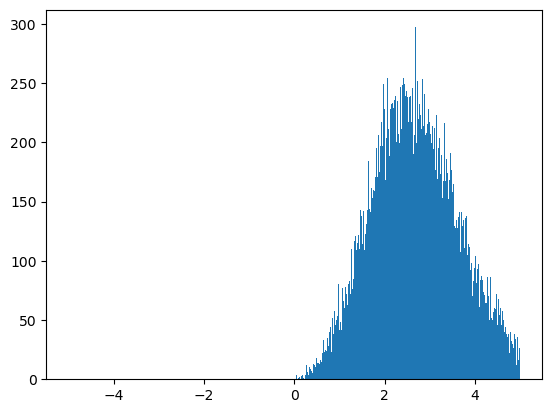

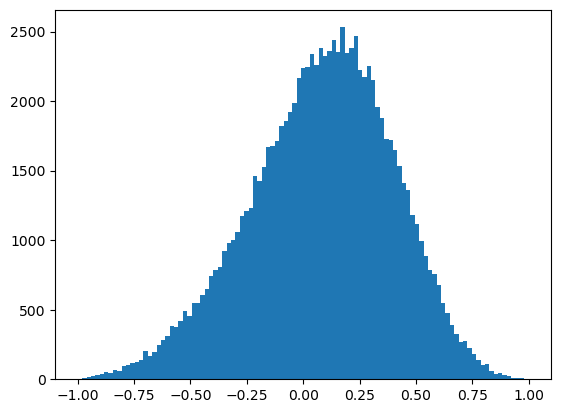

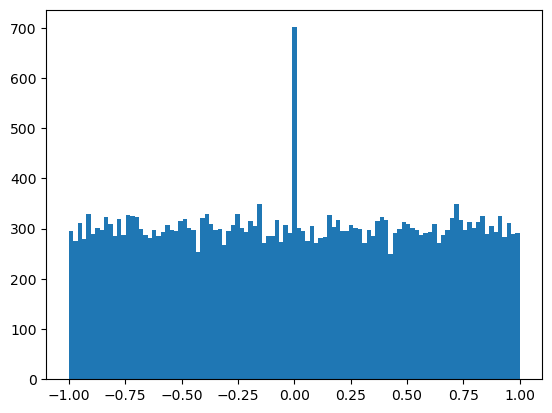

training model...
epoch 0


0it [00:00, ?it/s]W0212 15:53:19.995140 140321772836672 torch/fx/experimental/symbolic_shapes.py:4449] [4/48] ps0 is not in var_ranges, defaulting to unknown range.
W0212 15:53:24.885968 140321772836672 torch/fx/experimental/symbolic_shapes.py:4449] [4/49] ps0 is not in var_ranges, defaulting to unknown range.
W0212 15:53:27.379283 140321772836672 torch/fx/experimental/symbolic_shapes.py:4449] [4/50] ps0 is not in var_ranges, defaulting to unknown range.
W0212 15:53:29.859333 140321772836672 torch/fx/experimental/symbolic_shapes.py:4449] [4/51] ps0 is not in var_ranges, defaulting to unknown range.
W0212 15:53:33.217563 140321772836672 torch/fx/experimental/symbolic_shapes.py:4449] [4/52] ps0 is not in var_ranges, defaulting to unknown range.
W0212 15:53:35.686208 140321772836672 torch/fx/experimental/symbolic_shapes.py:4449] [4/53] ps0 is not in var_ranges, defaulting to unknown range.
W0212 15:53:38.140370 140321772836672 torch/fx/experimental/symbolic_shapes.py:4449] [4/54] ps0 is n

epoch 1


391it [00:29, 13.12it/s]


epoch 2


391it [00:29, 13.14it/s]


epoch 3


391it [00:29, 13.13it/s]


epoch 4


391it [00:29, 13.15it/s]


epoch 5


391it [00:30, 12.96it/s]


epoch 6


391it [00:29, 13.14it/s]


epoch 7


391it [00:29, 13.05it/s]



Test set: Avg. loss: 0.0103, Accuracy: 26218/50000 (52%)


Test set: Avg. loss: 0.0103, Accuracy: 5311/10000 (53%)

epoch 8


391it [00:29, 13.13it/s]


epoch 9


391it [00:29, 13.05it/s]


epoch 10


391it [00:29, 13.14it/s]


epoch 11


391it [00:29, 13.24it/s]


epoch 12


391it [00:29, 13.29it/s]


epoch 13


391it [00:29, 13.20it/s]


epoch 14


391it [00:29, 13.17it/s]


epoch 15


391it [00:29, 13.06it/s]



Test set: Avg. loss: 0.0085, Accuracy: 30462/50000 (61%)


Test set: Avg. loss: 0.0090, Accuracy: 5869/10000 (59%)

epoch 16


391it [00:29, 13.10it/s]


epoch 17


391it [00:29, 13.15it/s]


epoch 18


391it [00:29, 13.27it/s]


epoch 19


391it [00:29, 13.28it/s]


epoch 20


391it [00:29, 13.19it/s]


epoch 21


391it [00:29, 13.16it/s]


epoch 22


391it [00:29, 13.25it/s]


epoch 23


391it [00:29, 13.18it/s]



Test set: Avg. loss: 0.0069, Accuracy: 34159/50000 (68%)


Test set: Avg. loss: 0.0085, Accuracy: 6136/10000 (61%)

epoch 24


391it [00:29, 13.14it/s]


epoch 25


391it [00:29, 13.12it/s]


epoch 26


391it [00:29, 13.17it/s]


epoch 27


391it [00:29, 13.23it/s]


epoch 28


391it [00:29, 13.26it/s]


epoch 29


391it [00:29, 13.22it/s]


epoch 30


391it [00:29, 13.25it/s]


epoch 31


391it [00:29, 13.23it/s]



Test set: Avg. loss: 0.0055, Accuracy: 37516/50000 (75%)


Test set: Avg. loss: 0.0089, Accuracy: 6240/10000 (62%)

epoch 32


391it [00:29, 13.22it/s]


epoch 33


391it [00:29, 13.18it/s]


epoch 34


391it [00:29, 13.15it/s]


epoch 35


391it [00:29, 13.17it/s]


epoch 36


391it [00:29, 13.10it/s]


epoch 37


391it [00:29, 13.16it/s]


epoch 38


391it [00:29, 13.14it/s]


epoch 39


391it [00:29, 13.20it/s]



Test set: Avg. loss: 0.0042, Accuracy: 40588/50000 (81%)


Test set: Avg. loss: 0.0096, Accuracy: 6188/10000 (62%)

epoch 40


391it [00:29, 13.18it/s]


epoch 41


391it [00:29, 13.15it/s]


epoch 42


391it [00:29, 13.21it/s]


epoch 43


391it [00:29, 13.24it/s]


epoch 44


391it [00:29, 13.24it/s]


epoch 45


391it [00:29, 13.24it/s]


epoch 46


391it [00:29, 13.24it/s]


epoch 47


391it [00:29, 13.27it/s]



Test set: Avg. loss: 0.0032, Accuracy: 42996/50000 (86%)


Test set: Avg. loss: 0.0110, Accuracy: 6177/10000 (62%)

epoch 48


391it [00:29, 13.26it/s]


epoch 49


391it [00:29, 13.27it/s]


epoch 50


391it [00:29, 13.22it/s]


epoch 51


391it [00:29, 13.29it/s]


epoch 52


391it [00:29, 13.22it/s]


epoch 53


391it [00:29, 13.25it/s]


epoch 54


391it [00:29, 13.23it/s]


epoch 55


391it [00:29, 13.19it/s]



Test set: Avg. loss: 0.0026, Accuracy: 44349/50000 (89%)


Test set: Avg. loss: 0.0119, Accuracy: 6149/10000 (61%)

epoch 56


391it [00:29, 13.26it/s]


epoch 57


391it [00:29, 13.22it/s]


epoch 58


391it [00:29, 13.23it/s]


epoch 59


391it [00:29, 13.20it/s]


epoch 60


391it [00:29, 13.24it/s]


epoch 61


391it [00:29, 13.22it/s]


epoch 62


391it [00:29, 13.18it/s]


epoch 63


391it [00:29, 13.24it/s]



Test set: Avg. loss: 0.0020, Accuracy: 45756/50000 (92%)


Test set: Avg. loss: 0.0130, Accuracy: 6173/10000 (62%)

epoch 64


391it [00:29, 13.15it/s]


epoch 65


391it [00:29, 13.22it/s]


epoch 66


391it [00:29, 13.22it/s]


epoch 67


391it [00:29, 13.29it/s]


epoch 68


391it [00:29, 13.26it/s]


epoch 69


391it [00:29, 13.21it/s]


epoch 70


391it [00:29, 13.20it/s]


epoch 71


391it [00:29, 13.23it/s]



Test set: Avg. loss: 0.0017, Accuracy: 46316/50000 (93%)


Test set: Avg. loss: 0.0141, Accuracy: 6156/10000 (62%)

epoch 72


391it [00:29, 13.19it/s]


epoch 73


391it [00:29, 13.24it/s]


epoch 74


391it [00:29, 13.18it/s]


epoch 75


391it [00:29, 13.16it/s]


epoch 76


391it [00:29, 13.19it/s]


epoch 77


391it [00:29, 13.22it/s]


epoch 78


391it [00:29, 13.20it/s]


epoch 79


391it [00:29, 13.23it/s]



Test set: Avg. loss: 0.0015, Accuracy: 46875/50000 (94%)


Test set: Avg. loss: 0.0138, Accuracy: 6237/10000 (62%)

epoch 80


391it [00:29, 13.21it/s]


epoch 81


391it [00:29, 13.20it/s]


epoch 82


391it [00:29, 13.23it/s]


epoch 83


391it [00:29, 13.21it/s]


epoch 84


391it [00:29, 13.17it/s]


epoch 85


391it [00:29, 13.22it/s]


epoch 86


391it [00:29, 13.23it/s]


epoch 87


391it [00:29, 13.16it/s]



Test set: Avg. loss: 0.0013, Accuracy: 47150/50000 (94%)


Test set: Avg. loss: 0.0150, Accuracy: 6166/10000 (62%)

epoch 88


391it [00:29, 13.21it/s]


epoch 89


391it [00:29, 13.24it/s]


epoch 90


391it [00:29, 13.27it/s]


epoch 91


391it [00:29, 13.25it/s]


epoch 92


391it [00:29, 13.20it/s]


epoch 93


391it [00:29, 13.23it/s]


epoch 94


391it [00:29, 13.20it/s]


epoch 95


391it [00:29, 13.22it/s]



Test set: Avg. loss: 0.0010, Accuracy: 47852/50000 (96%)


Test set: Avg. loss: 0.0153, Accuracy: 6126/10000 (61%)

epoch 96


391it [00:29, 13.20it/s]


epoch 97


391it [00:29, 13.10it/s]


epoch 98


391it [00:29, 13.17it/s]


epoch 99


391it [00:29, 13.14it/s]


epoch 100


391it [00:29, 13.08it/s]


epoch 101


391it [00:29, 13.16it/s]


epoch 102


391it [00:29, 13.16it/s]


epoch 103


391it [00:29, 13.17it/s]



Test set: Avg. loss: 0.0009, Accuracy: 48021/50000 (96%)


Test set: Avg. loss: 0.0160, Accuracy: 6129/10000 (61%)

epoch 104


391it [00:29, 13.17it/s]


epoch 105


391it [00:29, 13.15it/s]


epoch 106


391it [00:29, 13.17it/s]


epoch 107


391it [00:29, 13.18it/s]


epoch 108


391it [00:29, 13.15it/s]


epoch 109


391it [00:29, 13.21it/s]


epoch 110


391it [00:29, 13.16it/s]


epoch 111


391it [00:29, 13.22it/s]



Test set: Avg. loss: 0.0008, Accuracy: 48391/50000 (97%)


Test set: Avg. loss: 0.0162, Accuracy: 6200/10000 (62%)

epoch 112


391it [00:29, 13.22it/s]


epoch 113


391it [00:29, 13.24it/s]


epoch 114


391it [00:29, 13.22it/s]


epoch 115


391it [00:29, 13.23it/s]


epoch 116


391it [00:29, 13.23it/s]


epoch 117


391it [00:29, 13.23it/s]


epoch 118


391it [00:29, 13.20it/s]


epoch 119


391it [00:29, 13.29it/s]



Test set: Avg. loss: 0.0007, Accuracy: 48456/50000 (97%)


Test set: Avg. loss: 0.0165, Accuracy: 6194/10000 (62%)

epoch 120


391it [00:29, 13.25it/s]


epoch 121


391it [00:29, 13.18it/s]


epoch 122


391it [00:29, 13.21it/s]


epoch 123


391it [00:29, 13.16it/s]


epoch 124


391it [00:29, 13.31it/s]


epoch 125


391it [00:29, 13.25it/s]


epoch 126


391it [00:29, 13.25it/s]


epoch 127


391it [00:29, 13.27it/s]



Test set: Avg. loss: 0.0006, Accuracy: 48732/50000 (97%)


Test set: Avg. loss: 0.0170, Accuracy: 6197/10000 (62%)

epoch 128


391it [00:29, 13.26it/s]


epoch 129


391it [00:29, 13.27it/s]


epoch 130


391it [00:29, 13.28it/s]


epoch 131


391it [00:29, 13.28it/s]


epoch 132


391it [00:29, 13.26it/s]


epoch 133


391it [00:29, 13.29it/s]


epoch 134


391it [00:29, 13.30it/s]


epoch 135


391it [00:29, 13.24it/s]



Test set: Avg. loss: 0.0005, Accuracy: 48936/50000 (98%)


Test set: Avg. loss: 0.0178, Accuracy: 6201/10000 (62%)

epoch 136


391it [00:29, 13.18it/s]


epoch 137


391it [00:29, 13.13it/s]


epoch 138


391it [00:29, 13.17it/s]


epoch 139


391it [00:29, 13.18it/s]


epoch 140


391it [00:29, 13.17it/s]


epoch 141


391it [00:29, 13.14it/s]


epoch 142


391it [00:29, 13.09it/s]


epoch 143


391it [00:29, 13.16it/s]



Test set: Avg. loss: 0.0005, Accuracy: 48988/50000 (98%)


Test set: Avg. loss: 0.0181, Accuracy: 6162/10000 (62%)

epoch 144


391it [00:29, 13.19it/s]


epoch 145


391it [00:29, 13.14it/s]


epoch 146


391it [00:29, 13.10it/s]


epoch 147


391it [00:29, 13.14it/s]


epoch 148


391it [00:29, 13.16it/s]


epoch 149


391it [00:29, 13.17it/s]


epoch 150


391it [00:29, 13.13it/s]


epoch 151


391it [00:29, 13.17it/s]



Test set: Avg. loss: 0.0004, Accuracy: 49159/50000 (98%)


Test set: Avg. loss: 0.0182, Accuracy: 6265/10000 (63%)

epoch 152


391it [00:29, 13.15it/s]


epoch 153


391it [00:29, 13.14it/s]


epoch 154


391it [00:29, 13.11it/s]


epoch 155


391it [00:29, 13.29it/s]


epoch 156


391it [00:29, 13.28it/s]


epoch 157


391it [00:29, 13.27it/s]


epoch 158


391it [00:29, 13.29it/s]


epoch 159


391it [00:29, 13.20it/s]



Test set: Avg. loss: 0.0004, Accuracy: 49265/50000 (99%)


Test set: Avg. loss: 0.0192, Accuracy: 6162/10000 (62%)

epoch 160


391it [00:29, 13.31it/s]


epoch 161


391it [00:29, 13.31it/s]


epoch 162


391it [00:29, 13.29it/s]


epoch 163


391it [00:29, 13.27it/s]


epoch 164


391it [00:29, 13.28it/s]


epoch 165


391it [00:29, 13.24it/s]


epoch 166


391it [00:29, 13.27it/s]


epoch 167


391it [00:29, 13.28it/s]



Test set: Avg. loss: 0.0003, Accuracy: 49336/50000 (99%)


Test set: Avg. loss: 0.0197, Accuracy: 6246/10000 (62%)

epoch 168


391it [00:29, 13.26it/s]


epoch 169


391it [00:29, 13.24it/s]


epoch 170


391it [00:29, 13.20it/s]


epoch 171


391it [00:29, 13.25it/s]


epoch 172


391it [00:29, 13.17it/s]


epoch 173


391it [00:29, 13.21it/s]


epoch 174


391it [00:29, 13.22it/s]


epoch 175


391it [00:29, 13.19it/s]



Test set: Avg. loss: 0.0003, Accuracy: 49462/50000 (99%)


Test set: Avg. loss: 0.0196, Accuracy: 6238/10000 (62%)

epoch 176


391it [00:29, 13.22it/s]


epoch 177


391it [00:29, 13.19it/s]


epoch 178


391it [00:29, 13.23it/s]


epoch 179


391it [00:29, 13.23it/s]


epoch 180


391it [00:29, 13.26it/s]


epoch 181


391it [00:29, 13.26it/s]


epoch 182


391it [00:29, 13.20it/s]


epoch 183


391it [00:29, 13.22it/s]



Test set: Avg. loss: 0.0002, Accuracy: 49511/50000 (99%)


Test set: Avg. loss: 0.0201, Accuracy: 6187/10000 (62%)

epoch 184


391it [00:29, 13.26it/s]


epoch 185


391it [00:29, 13.25it/s]


epoch 186


391it [00:29, 13.27it/s]


epoch 187


391it [00:29, 13.25it/s]


epoch 188


391it [00:29, 13.28it/s]


epoch 189


391it [00:29, 13.24it/s]


epoch 190


391it [00:29, 13.10it/s]


epoch 191


391it [00:29, 13.12it/s]



Test set: Avg. loss: 0.0002, Accuracy: 49618/50000 (99%)


Test set: Avg. loss: 0.0207, Accuracy: 6213/10000 (62%)

epoch 192


391it [00:29, 13.13it/s]


epoch 193


391it [00:29, 13.16it/s]


epoch 194


391it [00:29, 13.22it/s]


epoch 195


391it [00:29, 13.23it/s]


epoch 196


391it [00:29, 13.30it/s]


epoch 197


391it [00:29, 13.32it/s]


epoch 198


391it [00:29, 13.20it/s]


epoch 199


391it [00:29, 13.23it/s]



Test set: Avg. loss: 0.0002, Accuracy: 49664/50000 (99%)


Test set: Avg. loss: 0.0208, Accuracy: 6241/10000 (62%)

epoch 200


391it [00:29, 13.26it/s]


epoch 201


391it [00:29, 13.27it/s]


epoch 202


391it [00:29, 13.28it/s]


epoch 203


391it [00:29, 13.30it/s]


epoch 204


391it [00:29, 13.28it/s]


epoch 205


391it [00:29, 13.29it/s]


epoch 206


391it [00:29, 13.24it/s]


epoch 207


391it [00:29, 13.23it/s]



Test set: Avg. loss: 0.0002, Accuracy: 49717/50000 (99%)


Test set: Avg. loss: 0.0210, Accuracy: 6248/10000 (62%)

epoch 208


391it [00:29, 13.13it/s]


epoch 209


391it [00:29, 13.14it/s]


epoch 210


391it [00:29, 13.14it/s]


epoch 211


391it [00:29, 13.09it/s]


epoch 212


391it [00:29, 13.04it/s]


epoch 213


391it [00:29, 13.11it/s]


epoch 214


391it [00:29, 13.15it/s]


epoch 215


391it [00:29, 13.28it/s]



Test set: Avg. loss: 0.0001, Accuracy: 49727/50000 (99%)


Test set: Avg. loss: 0.0211, Accuracy: 6253/10000 (63%)

epoch 216


391it [00:29, 13.27it/s]


epoch 217


391it [00:29, 13.27it/s]


epoch 218


391it [00:29, 13.24it/s]


epoch 219


391it [00:29, 13.25it/s]


epoch 220


391it [00:29, 13.28it/s]


epoch 221


391it [00:29, 13.22it/s]


epoch 222


391it [00:29, 13.24it/s]


epoch 223


391it [00:29, 13.14it/s]



Test set: Avg. loss: 0.0001, Accuracy: 49714/50000 (99%)


Test set: Avg. loss: 0.0211, Accuracy: 6241/10000 (62%)

epoch 224


391it [00:30, 12.99it/s]


epoch 225


391it [00:29, 13.17it/s]


epoch 226


338it [00:25, 13.07it/s]

In [15]:
from shearletNN.deit import deit_tiny_patch1_LS
from shearletNN.shearlet_utils import fourier_pooling_transform
import torchaudio

train_loader = torch.utils.data.DataLoader(
    ds_train, batch_size=batch_size_train, shuffle=True, num_workers=0
)

val_loader = torch.utils.data.DataLoader(
    ds_val, batch_size=batch_size_train, shuffle=False
)

def pooling_transform(img):
    img = fourier_pooling_transform(img.to(0), shearlets.to(0), patch_size)
    phase = torch.angle(img)
    mag = torch.sqrt((img.real ** 2) + (img.imag ** 2))
    mag = symlog(torch.abs(img))
    return mag

train_loader = ShearletTransformLoader(train_loader, pooling_transform)
val_loader = ShearletTransformLoader(val_loader, pooling_transform)

a_max = None
a_min = None

for x, y in train_loader:
    # this should be the max elementwise and pixelwise as different ones are likely to have different ranges
    a_max = torch.maximum(torch.max(x, dim=0)[0], a_max if a_max is not None else torch.max(x, dim=0)[0])
    a_min = torch.minimum(torch.min(x, dim=0)[0], a_min if a_min is not None else torch.min(x, dim=0)[0])
else:
    plt.hist(x.flatten().real.cpu().numpy(), bins=1023, range=[-5, 5])
    plt.show()

a_max, a_min = a_max.unsqueeze(0), a_min.unsqueeze(0)

train_loader = torch.utils.data.DataLoader(
    ds_train, batch_size=batch_size_train, shuffle=True, num_workers=0
)

val_loader = torch.utils.data.DataLoader(
    ds_val, batch_size=batch_size_train, shuffle=False
)

def pooling_transform(img):
    img = fourier_pooling_transform(img.to(0), shearlets.to(0), patch_size)
    phase = torch.angle(img)
    mag = torch.sqrt((img.real ** 2) + (img.imag ** 2))

    phase = phase.nan_to_num()
    mag = (2*(symlog(mag) - a_min) / (a_max - a_min)) - 1

    img = torch.cat((mag, phase), 1)

    return img

train_loader = ShearletTransformLoader(train_loader, pooling_transform)
val_loader = ShearletTransformLoader(val_loader, pooling_transform)

torch.set_float32_matmul_precision('high')

model = torch.nn.Sequential(torch.nn.Conv2d(6, 12, 3, 1, 'same'), deit_tiny_patch1_LS(in_chans=12))
model = torch.compile(model)

# model = spectral_normalize(model)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 240)

for x, y in train_loader:
    plt.hist(x[:, :x.shape[1] // 2].flatten().real.cpu().numpy(), bins=103, range=[-1, 1])
    plt.show()
    plt.hist(x[:, x.shape[1] // 2:].flatten().real.cpu().numpy(), bins=103, range=[-1, 1])
    plt.show()
    break

print("training model...")
for epoch in range(240):
    print("epoch", epoch)
    train(model.to(0), optimizer, train_loader, accumulate=2)
    gc.collect()
    if epoch % 8 == 7:
        test(model, train_loader)
        test(model, val_loader)
    scheduler.step()

In [ ]:
from shearletNN.deit import deit_tiny_patch2_LS
from shearletNN.shearlet_utils import fourier_pooling_transform

train_loader = torch.utils.data.DataLoader(
    ds_train, batch_size=batch_size_train, shuffle=True, num_workers=0
)

val_loader = torch.utils.data.DataLoader(
    ds_val, batch_size=batch_size_train, shuffle=False
)

def pooling_transform(img):
    img = fourier_pooling_transform(img.to(0), shearlets.to(0), patch_size)
    phase = torch.tanh(img.real / img.imag) / torch.math.pi
    phase = phase.nan_to_num()
    mag = torch.abs(img) 

    img = torch.cat((mag, phase), 1)

    return img

train_loader = ShearletTransformLoader(train_loader, pooling_transform)
val_loader = ShearletTransformLoader(val_loader, pooling_transform)

a_max = 0
a_min = 0

for x, y in train_loader:
    a_max = max(x[:, :x.shape[1] // 2].max(), a_max)
    a_min = min(x[:, :x.shape[1] // 2].min(), a_min)

train_loader = torch.utils.data.DataLoader(
    ds_train, batch_size=batch_size_train, shuffle=True, num_workers=0
)

val_loader = torch.utils.data.DataLoader(
    ds_val, batch_size=batch_size_train, shuffle=False
)

def pooling_transform(img):
    img = fourier_pooling_transform(img.to(0), shearlets.to(0), patch_size)
    phase = torch.tanh(img.real / img.imag) / torch.math.pi
    phase = phase.nan_to_num()
    mag = (2*(torch.abs(img) - a_min) / (a_max - a_min)) - 1

    img = torch.cat((mag, phase), 1)

    return img

train_loader = ShearletTransformLoader(train_loader, pooling_transform)
val_loader = ShearletTransformLoader(val_loader, pooling_transform)

model = complex_resnet18(in_dim = 6, img_size=patch_size)

# model = spectral_normalize(model)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 240)

print("training model...")
for epoch in range(240):
    print("epoch", epoch)
    train(model.to(0), optimizer, train_loader, accumulate=2)
    gc.collect()
    if epoch % 3 == 2: #  and epoch > 24:
        test(model, train_loader)
        test(model, val_loader)
    scheduler.step()

In [ ]:
# if this does not achieve 61 percent then it is worse than a different layer for each input
# model = complex_freakformer_tiny_patch4_LS(
#     img_size=image_size, in_chans=shearlets.shape[0] * 3
# )
# 85% at the 64p resolution spatial, 75% at the 32p resolution, 79% at 32p compressed from 64
# not using the sqrt + symlog is worse
# using symlog only is better (81%)
# 71% at 16p

# on caltech 101 65% at 32p

train_loader = torch.utils.data.DataLoader(
    ds_train, batch_size=batch_size_train, shuffle=True, num_workers=0
)

val_loader = torch.utils.data.DataLoader(
    ds_val, batch_size=batch_size_train, shuffle=False
)

def shearlet_transform(img):
    return hartley_shearlet_transform(img.to(0), shearlets.to(0), patch_size)

train_loader = ShearletTransformLoader(train_loader, shearlet_transform)
val_loader = ShearletTransformLoader(val_loader, shearlet_transform)


model = complex_resnet18(in_dim = shearlets.shape[0] * 3, complex=False)

model = spectral_normalize(model)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 240)

print("training model...")
for epoch in range(240):
    print("epoch", epoch)
    train(model.to(0), optimizer, train_loader, accumulate=2)
    gc.collect()
    if epoch % 8 == 7 and epoch > 24:
        test(model, train_loader)
        test(model, val_loader)
    scheduler.step()

In [ ]:
from shearletNN.shearlet_utils import hartley_pooling_transform

train_loader = torch.utils.data.DataLoader(
    ds_train, batch_size=batch_size_train, shuffle=True, num_workers=0
)

val_loader = torch.utils.data.DataLoader(
    ds_val, batch_size=batch_size_train, shuffle=False
)

def pooling_transform(img):
    return hartley_pooling_transform(img.to(0), shearlets.to(0), patch_size)

train_loader = ShearletTransformLoader(train_loader, pooling_transform)
val_loader = ShearletTransformLoader(val_loader, pooling_transform)

model = complex_resnet18(in_dim = 3, complex=False)

model = spectral_normalize(model)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 240)

print("training model...")
for epoch in range(240):
    print("epoch", epoch)
    train(model.to(0), optimizer, train_loader, accumulate=2)
    gc.collect()
    if epoch % 8 == 7 and epoch > 24:
        test(model, train_loader)
        test(model, val_loader)
    scheduler.step()

In [ ]:
from shearletNN.shearlet_utils import fourier_pooling_transform

train_loader = torch.utils.data.DataLoader(
    ds_train, batch_size=batch_size_train, shuffle=True, num_workers=0
)

val_loader = torch.utils.data.DataLoader(
    ds_val, batch_size=batch_size_train, shuffle=False
)

def pooling_transform(img):
    return fourier_pooling_transform(img.to(0), shearlets.to(0), patch_size)

train_loader = ShearletTransformLoader(train_loader, pooling_transform)
val_loader = ShearletTransformLoader(val_loader, pooling_transform)

model = complex_resnet18(in_dim = 3, complex=False)

model = spectral_normalize(model)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 240)

print("training model...")
for epoch in range(240):
    print("epoch", epoch)
    train(model.to(0), optimizer, train_loader, accumulate=2)
    gc.collect()
    if epoch % 8 == 7 and epoch > 24:
        test(model, train_loader)
        test(model, val_loader)
    scheduler.step()

In [ ]:
from shearletNN.deit import deit_small_patch16_LS


def repeat3(x):
    return x.repeat(3, 1, 1)[:3]


train_transform = v2.Compose(
    [
        transforms.RandomResizedCrop((patch_size, patch_size), scale=(0.5, 1.0)),
        # transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        repeat3,
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

val_transform = v2.Compose(
    [
        transforms.Resize((patch_size, patch_size)),
        transforms.ToTensor(),
        repeat3,
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

ds_train = torchvision.datasets.Caltech101(
    "./", transform=train_transform, download=True
)
ds_train = IndexSubsetDataset(
    ds_train, sum([list(range(len(ds_train)))[i::5] for i in range(1, 5)], [])
)

ds_val = torchvision.datasets.Caltech101("./", transform=val_transform, download=True)
ds_val = IndexSubsetDataset(ds_val, list(range(len(ds_val)))[0::5])


ds_train = torchvision.datasets.CIFAR10(
    "../", transform=train_transform, download=True, train=True
)

ds_val = torchvision.datasets.CIFAR10(
    "../", transform=val_transform, download=True, train=False
)


train_loader = torch.utils.data.DataLoader(
    ds_train, batch_size=batch_size_train, shuffle=False, num_workers=0
)


val_loader = torch.utils.data.DataLoader(
    ds_val, batch_size=batch_size_train, shuffle=False
)


for x, y in tqdm(train_loader):
    assert list(x.shape) == [
        batch_size_train,
        # 2 * shearlets.shape[0] * 3,
        3,
        patch_size,
        patch_size,
    ], x.shape
    assert x.dtype == torch.float32, x.dtype
    print(x.real.mean((0, 2, 3)))

    print(x.real.std((0, 2, 3)))

    print(x.real.max())

    plt.imshow(x[0].sum(0).real.cpu().numpy())
    plt.show()
    plt.hist(x.flatten().real.cpu().numpy(), bins=501, range=[-3, 3])
    plt.show()
    break
print("building model...")

# 61% with the spatial frequency components
# model = deit_small_patch16_LS(img_size=patch_size, in_chans=2 * shearlets.shape[0] * 3)
model = torchvision.models.resnet18()

model = spectral_normalize(model)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 240)

print("training model...")
for epoch in range(240):
    print("epoch", epoch)
    train(model.to(0), optimizer, train_loader, accumulate=2)
    gc.collect()
    if epoch % 8 == 7 and epoch > 24:
        test(model, train_loader)
        test(model, val_loader)
    scheduler.step()

In [ ]:
class FourierConvolution(torch.nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.weight = torch.nn.Parameter(input_size)


class FourierCNN(torch.nn.Module):
    def __init__(self, input_size):
        super().__init__()
        input_dim = 1

        for i in input_size:
            input_dim *= i

        layers = torch.nn.ModuleList([
            torch.nn.Linear(input_dim, 1024, dtype=torch.complex64),
            CGELU(),
            torch.nn.Linear(input_dim, 1024, dtype=torch.complex64),
            CGELU(),
            torch.nn.Linear(input_dim, 1024, dtype=torch.complex64),
            CGELU(),
            torch.nn.Linear(input_dim, 1024, dtype=torch.complex64),
            ])



In [ ]:
from shearletNN.complex_deit import (
    vit_models,
    LPatchEmbed,
    Attention,
    Block,
    ComplexLayerNorm,
    complex_rope_mixed_ape_deit_small_patch4_LS,
)
from shearletNN.layers import CReLU, ComplexLayerNorm
from functools import partial


def repeat3(x):
    return x.repeat(3, 1, 1)[:3]


train_transform = v2.Compose(
    [
        transforms.RandomResizedCrop((image_size, image_size), scale=(0.5, 1.0)),
        # transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        repeat3,
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

val_transform = v2.Compose(
    [
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        repeat3,
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

ds_train = torchvision.datasets.Caltech101(
    "./", transform=train_transform, download=True
)
ds_train = IndexSubsetDataset(
    ds_train, sum([list(range(len(ds_train)))[i::5] for i in range(1, 5)], [])
)

ds_val = torchvision.datasets.Caltech101("./", transform=val_transform, download=True)
ds_val = IndexSubsetDataset(ds_val, list(range(len(ds_val)))[0::5])

train_loader = torch.utils.data.DataLoader(
    ds_train, batch_size=batch_size_train, shuffle=True, num_workers=0
)

shearlets = shearlets[:]


def shearlet_transform(img):
    return norm(complex_symsqrt(spatial_shearlet_transform(img.to(0), shearlets.to(0), patch_size)))


train_loader = ShearletTransformLoader(train_loader, shearlet_transform)

val_loader = torch.utils.data.DataLoader(
    ds_val, batch_size=batch_size_train, shuffle=False
)

val_loader = ShearletTransformLoader(val_loader, shearlet_transform)

for x, y in tqdm(train_loader):
    assert list(x.shape) == [
        batch_size_train,
        shearlets.shape[0] * 3,
        patch_size,
        patch_size,
    ], x.shape
    assert x.dtype == torch.complex64, x.dtype
    print(x.real.mean((0, 2, 3)))
    print(x.imag.mean((0, 2, 3)))
    print(x.imag.std((0, 2, 3)))
    print(x.imag.std((0, 2, 3)))
    break
print("building model...")

# if this does not achieve 61 percent then it is worse than a different layer for each input
model = complex_rope_mixed_ape_deit_small_patch4_LS(
     img_size=patch_size, in_chans=shearlets.shape[0] * 3
)

model = spectral_normalize(model)


optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 240)

print("training model...")
for epoch in range(240):
    print("epoch", epoch)
    train(model.to(0), optimizer, train_loader, accumulate=2)
    gc.collect()
    if epoch % 4 == 3:
        test(model, train_loader)
        test(model, val_loader)
    scheduler.step()

In [ ]:
from shearletNN.complex_deit import (
    vit_models,
    LPatchEmbed,
    Attention,
    Block,
    ComplexLayerNorm,
    complex_Lfreakformer_small_patch1_LS,
)
from shearletNN.layers import CReLU, ComplexLayerNorm
from functools import partial


def repeat3(x):
    return x.repeat(3, 1, 1)[:3]


train_transform = v2.Compose(
    [
        transforms.RandomResizedCrop((image_size, image_size), scale=(0.5, 1.0)),
        # transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        repeat3,
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

val_transform = v2.Compose(
    [
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        repeat3,
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

ds_train = torchvision.datasets.Caltech101(
    "./", transform=train_transform, download=True
)
ds_train = IndexSubsetDataset(
    ds_train, sum([list(range(len(ds_train)))[i::5] for i in range(1, 5)], [])
)

ds_val = torchvision.datasets.Caltech101("./", transform=val_transform, download=True)
ds_val = IndexSubsetDataset(ds_val, list(range(len(ds_val)))[0::5])

ds_train = torchvision.datasets.CIFAR10(
    "../", transform=train_transform, download=True, train=True
)

ds_val = torchvision.datasets.CIFAR10(
    "../", transform=val_transform, download=True, train=False
)

train_loader = torch.utils.data.DataLoader(
    ds_train, batch_size=batch_size_train, shuffle=True, num_workers=0
)

shearlets = shearlets[:]


def shearlet_transform(img):
    return norm(complex_symsqrt(complex_symlog(shifted_spatial_shearlet_transform(img.to(0), shearlets.to(0), patch_size))))


train_loader = ShearletTransformLoader(train_loader, shearlet_transform)

val_loader = torch.utils.data.DataLoader(
    ds_val, batch_size=batch_size_train, shuffle=False
)

val_loader = ShearletTransformLoader(val_loader, shearlet_transform)

for x, y in tqdm(train_loader):
    assert list(x.shape) == [
        batch_size_train,
        shearlets.shape[0] * 3,
        patch_size,
        patch_size,
    ], x.shape
    assert x.dtype == torch.complex64, x.dtype
    print(x.real.mean((0, 2, 3)))
    print(x.imag.mean((0, 2, 3)))
    print(x.imag.std((0, 2, 3)))
    print(x.imag.std((0, 2, 3)))
    break
print("building model...")

# if this does not achieve 61 percent then it is worse than a different layer for each input
model = complex_freakformer_tiny_patch4_LS(
     img_size=patch_size, in_chans=shearlets.shape[0] * 3
)

with torch.no_grad():
    for param in model.parameters():
        if not ((param == 0).all() or (param == 1).all()):
            param.data /= 2 ** (0.5)
        if param.is_complex():
            param.data = param.data.type(torch.complex64)

model = spectral_normalize(model)


optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 240)

print("training model...")
for epoch in range(240):
    print("epoch", epoch)
    train(model.to(0), optimizer, train_loader, accumulate=2)
    gc.collect()
    if epoch % 4 == 3:
        test(model, train_loader)
        test(model, val_loader)
    scheduler.step()

In [ ]:
from shearletNN.complex_deit import (
    vit_models,
    LPatchEmbed,
    Attention,
    Block,
    ComplexLayerNorm,
    complex_Lfreakformer_small_patch1_LS,
)
from shearletNN.layers import CReLU, ComplexLayerNorm
from functools import partial


def repeat3(x):
    return x.repeat(3, 1, 1)[:3]


train_transform = v2.Compose(
    [
        transforms.RandomResizedCrop((image_size, image_size), scale=(0.5, 1.0)),
        # transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        repeat3,
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

val_transform = v2.Compose(
    [
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        repeat3,
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

ds_train = torchvision.datasets.Caltech101(
    "./", transform=train_transform, download=True
)
ds_train = IndexSubsetDataset(
    ds_train, sum([list(range(len(ds_train)))[i::5] for i in range(1, 5)], [])
)

ds_val = torchvision.datasets.Caltech101("./", transform=val_transform, download=True)
ds_val = IndexSubsetDataset(ds_val, list(range(len(ds_val)))[0::5])

ds_train = torchvision.datasets.CIFAR10(
    "../", transform=train_transform, download=True, train=True
)

ds_val = torchvision.datasets.CIFAR10(
    "../", transform=val_transform, download=True, train=False
)

train_loader = torch.utils.data.DataLoader(
    ds_train, batch_size=batch_size_train, shuffle=True, num_workers=0
)

shearlets = shearlets[:]


def shearlet_transform(img):
    return norm(complex_symsqrt(complex_symlog(shifted_spatial_shearlet_transform(img.to(0), shearlets.to(0), patch_size))))


train_loader = ShearletTransformLoader(train_loader, shearlet_transform)

val_loader = torch.utils.data.DataLoader(
    ds_val, batch_size=batch_size_train, shuffle=False
)

val_loader = ShearletTransformLoader(val_loader, shearlet_transform)

for x, y in tqdm(train_loader):
    assert list(x.shape) == [
        batch_size_train,
        shearlets.shape[0] * 3,
        patch_size,
        patch_size,
    ], x.shape
    assert x.dtype == torch.complex64, x.dtype
    print(x.real.mean((0, 2, 3)))
    print(x.imag.mean((0, 2, 3)))
    print(x.imag.std((0, 2, 3)))
    print(x.imag.std((0, 2, 3)))
    break
print("building model...")

# if this does not achieve 61 percent then it is worse than a different layer for each input
model = complex_Lfreakformer_tiny_patch4_LS(
     img_size=patch_size, in_chans=shearlets.shape[0] * 3
)

with torch.no_grad():
    for param in model.parameters():
        if not ((param == 0).all() or (param == 1).all()):
            param.data /= 2 ** (0.5)
        if param.is_complex():
            param.data = param.data.type(torch.complex64)

model = spectral_normalize(model)


optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 240)

print("training model...")
for epoch in range(240):
    print("epoch", epoch)
    train(model.to(0), optimizer, train_loader, accumulate=2)
    gc.collect()
    if epoch % 4 == 3:
        test(model, train_loader)
        test(model, val_loader)
    scheduler.step()